In [2]:
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#Code citation from https://stackoverflow.com/questions/23073170/calculate-bounding-polygon-of-alpha-shape-from-the-delaunay-triangulation

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa   = points[ia]
        pb   = points[ib]
        pc   = points[ic]
        a    = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b    = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c    = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s    = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)

    return edges

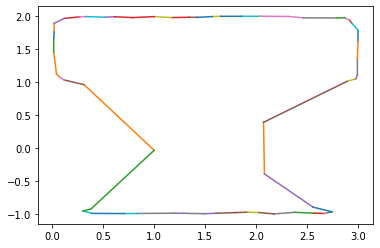

In [3]:
x = points[:,0].flatten()
y = points[:,1].flatten()

edges = alpha_shape(points, alpha=1, only_outer=True)
es = np.array(list(edges))
u = plt.plot(x[es.T], y[es.T]) 

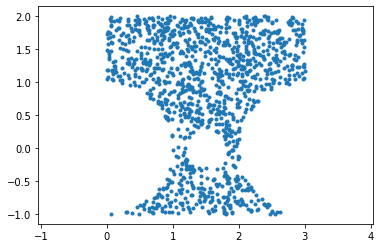

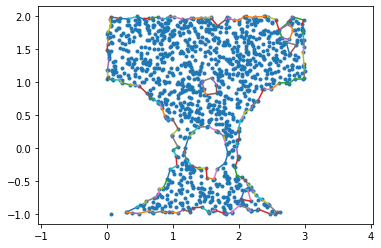

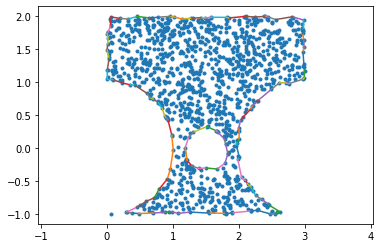

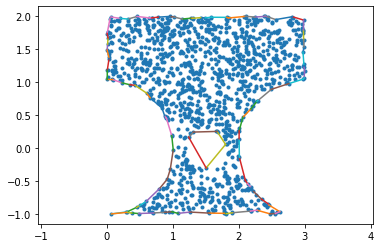

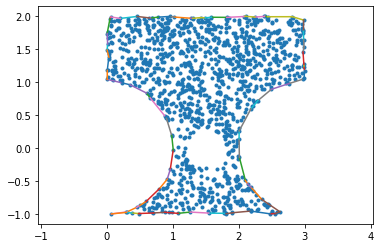

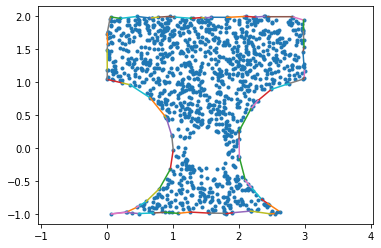

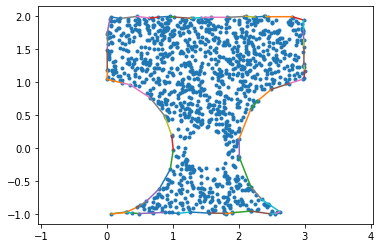

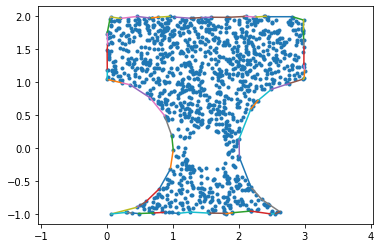

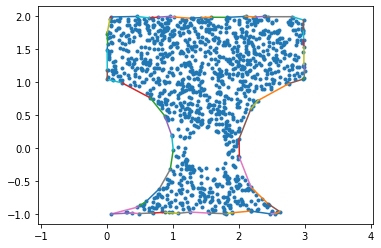

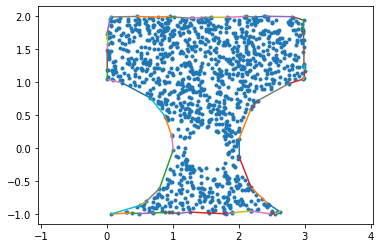

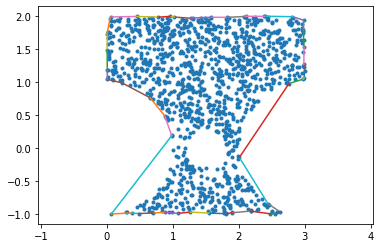

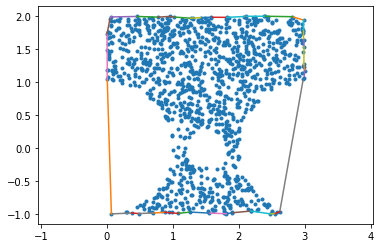

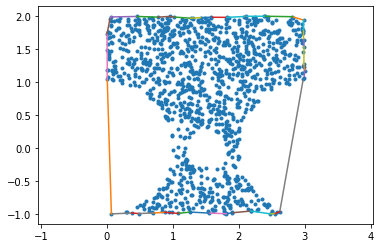

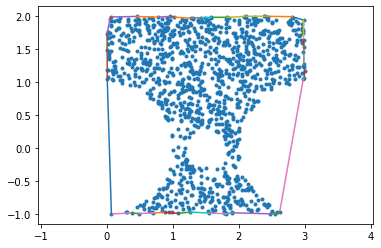

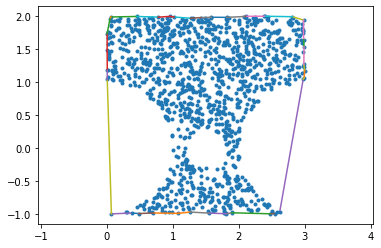

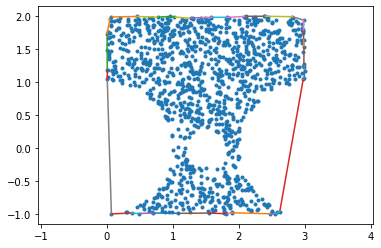

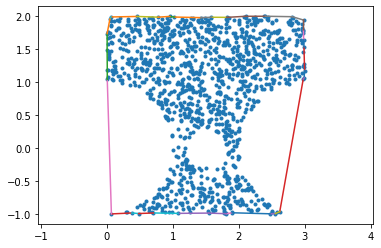

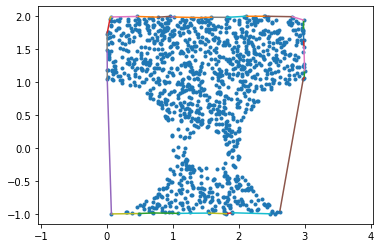

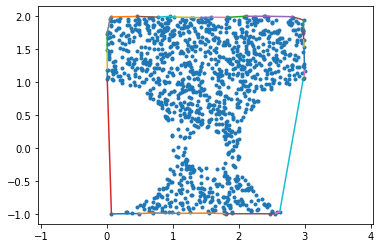

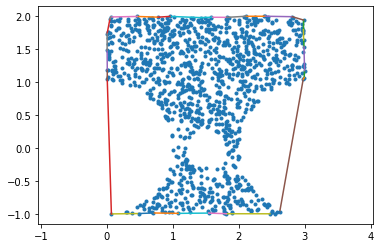

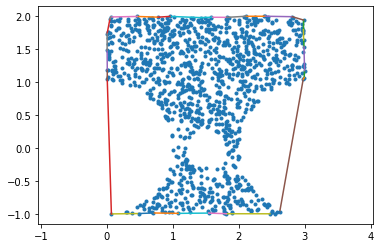

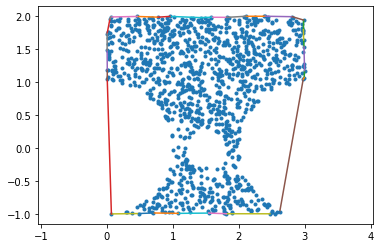

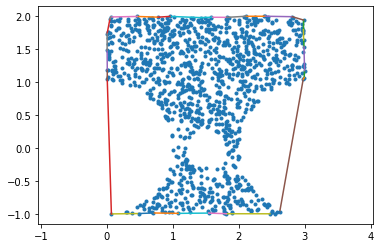

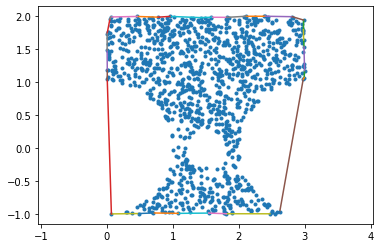

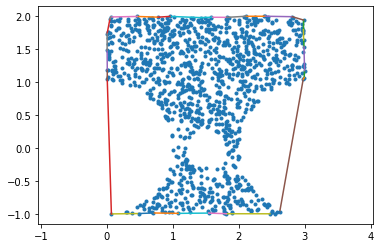

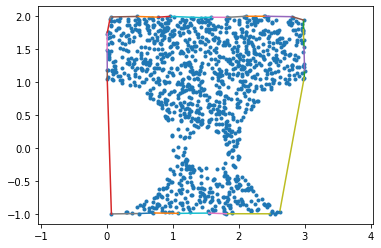

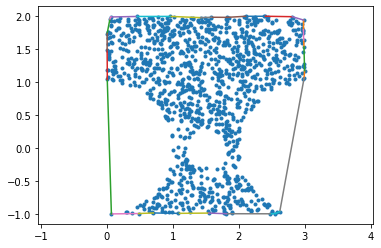

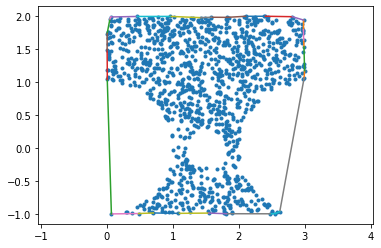

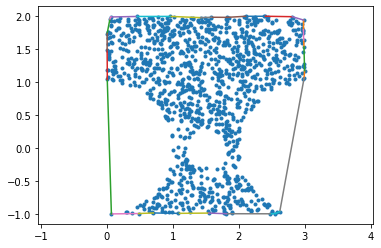

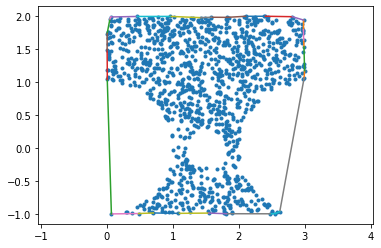

In [4]:
from matplotlib.pyplot import *

x      = 3.0 * np.random.rand(2000)
y      = 3.0 * np.random.rand(2000) - 1.0
inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0) & ((x - 1.5) ** 2 + y ** 2 > 0.09))
points = np.vstack([x[inside], y[inside]]).T

# Computing the alpha shape

alpha_r = [0.1*x for x in range(30)]


for alfa in alpha_r:
    edges = alpha_shape(points, alpha=alfa, only_outer=True)

    # Plotting the output
    figure()
    axis('equal')
    plot(points[:, 0], points[:, 1], '.')
    for i, j in edges:
        plot(points[[i, j], 0], points[[i, j], 1])
        #plt.rcParams["axes.grid"] = False
    show()


    
    

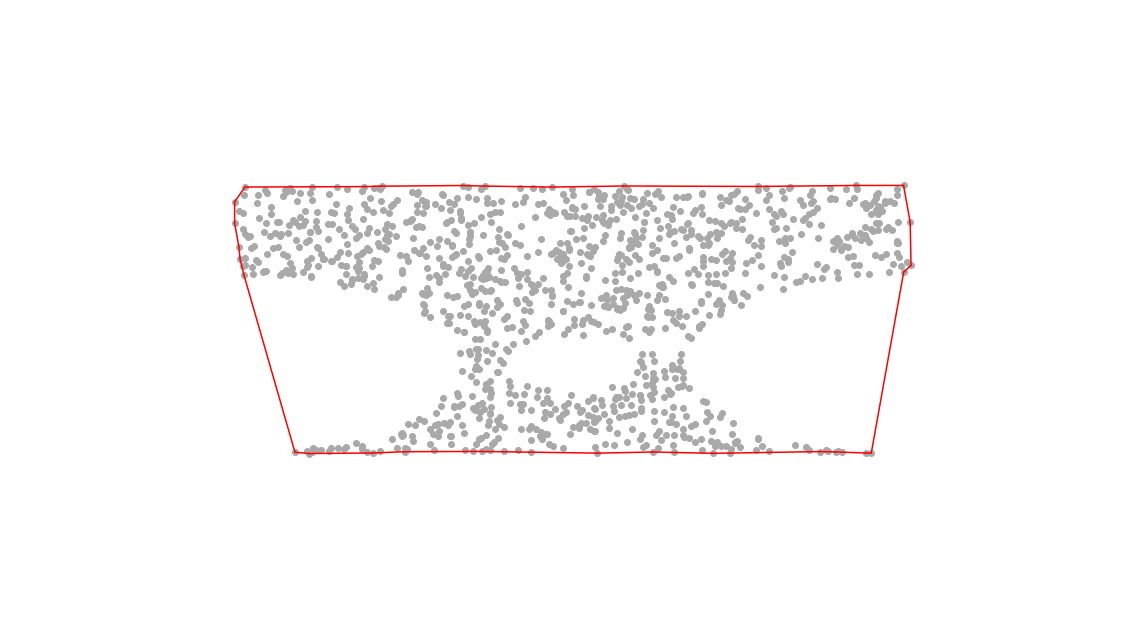

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

x       = 3.0 * np.random.rand(2000)
y       = 3.0 * np.random.rand(2000) - 1.0
inside  = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0) & ((x - 1.5) ** 2 + y ** 2 > 0.09))
points  = np.vstack([x[inside], y[inside]]).T

fig, ax = plt.subplots(figsize=(16, 9))
ax.set_xlim(-1, 4)
ax.set_ylim(-3, 4)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
ln1,    = plt.plot([x for x, y in points], [y for x, y in points], color='darkgrey', marker='o', linestyle='None')

fig.patch.set_alpha(0.)
fig.tight_layout()

alphas  = np.concatenate([np.linspace(0.01, 0.4, 80), np.linspace(0.45, 2, 20)])

idx     = np.argmax([len(alpha_shape(points, alpha=alpha, only_outer=True)) for alpha in alphas])
edges   = alpha_shape(points, alpha=alphas[idx], only_outer=True)
x       = points[:,0].flatten()
y       = points[:,1].flatten()
es      = np.array(list(edges))
lines   = plt.plot(x[es.T], y[es.T], linestyle='-', color='red', markerfacecolor='red')

def update(item):
    
    idy, alpha = item
    
    edges = alpha_shape(points, alpha=alpha, only_outer=True)
    x     = points[:,0].flatten()
    y     = points[:,1].flatten()
    es    = np.array(list(edges))

    els   = [([[x1], [x2]], [[y1], [y2]]) for x1, x2, y1, y2 in zip(x[es.T][0], x[es.T][1], y[es.T][0], y[es.T][1])]
    els   += [([[], []], [[], []])] * (len(lines) - len(edges))
    
    for idx, el in enumerate(els):
        lines[idx].set_data(el)
    
    fig.savefig(f"frames/{idy:03}.png")
    return lines

anim = FuncAnimation(fig, update, frames=enumerate(alphas), blit=True, interval=150)
anim.save('alpha.gif', writer='imagemagick', fps=10, savefig_kwargs={'transparent': True, 'facecolor': 'none'})

# anim.save('alpha_transparent.mov', codec="png", dpi=100, bitrate=-1, savefig_kwargs={'transparent': True, 'facecolor': 'none'})
# HTML(anim.to_html5_video())